In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import scipy.io as sio

In [2]:
"""
data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})
"""

data = sio.loadmat('mnist_binary_small.mat')
Xtrain = data['Xtrain']
Xtest = data['Xtest']
ytrain = data['ytrain'][0,:]
ytest = data['ytest'][0,:]

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)


(1958, 784) (1991, 784) (1958,) (1991,)


In [3]:
def get_weighted_misclass(w, y, yhat):
    return np.sum(w[y != yhat]) / np.sum(w)


def get_misclassed(y, yhat):
    return np.sum(y != yhat) / len(y)


def get_exp_loss(y, yhat):
    return np.mean(np.exp(-y * yhat))


# Create a decision tree classifier of depth 1 and calculate the train misclassification
# the test misclassification and the test exponential loss
clf = tree.DecisionTreeClassifier(max_depth=1)
clf.fit(Xtrain, ytrain)
yhat_train = clf.predict(Xtrain)
yhat_test = clf.predict(Xtest)
print(f"{get_misclassed(ytrain,yhat_train) * 100:.2f}% train misclassification\
        {get_misclassed(ytest,yhat_test) * 100:.2f}% test misclassification\
        {get_exp_loss(ytrain,yhat_train)} exponential loss")


10.98% train misclassification        15.27% test misclassification        0.6259675480492947 exponential loss


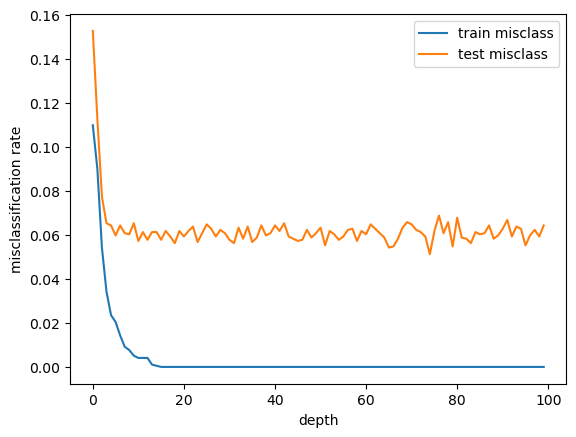

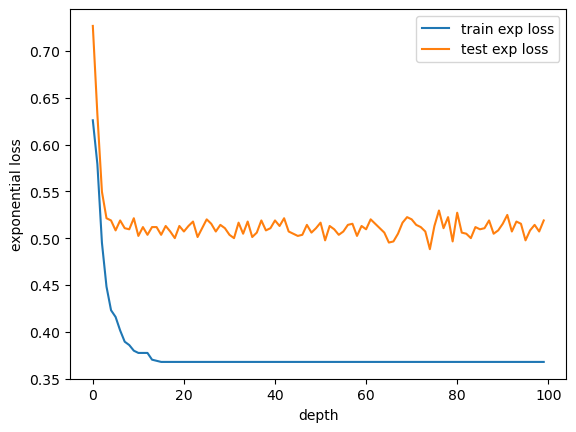

min train misclass 0.0
min test misclass 0.051230537418382724
min train exp loss 0.3678794411714424
min test exp loss 0.48829181862163606


In [4]:
# Deep Trees
# Use tree library from sklearn to train trees with depth 1 to 100
# Plot the misclassification rate, and exponential loss as a function of depth
# Also report the smallest train and test misclassification rate and smallest exponential loss
def plot_tree_depth(Xtrain,ytrain,Xtest,ytest):
    train_misclass = []
    test_misclass = []
    train_exp_loss = []
    test_exp_loss = []
    for i in range(1,101):
        clf = tree.DecisionTreeClassifier(max_depth=i)
        clf = clf.fit(Xtrain,ytrain)
        yhat_train = clf.predict(Xtrain)
        yhat_test = clf.predict(Xtest)
        train_misclass.append(get_misclassed(ytrain,yhat_train))
        test_misclass.append(get_misclassed(ytest,yhat_test))
        train_exp_loss.append(get_exp_loss(ytrain,yhat_train))
        test_exp_loss.append(get_exp_loss(ytest,yhat_test))
    plt.plot(train_misclass)
    plt.plot(test_misclass)
    plt.legend(['train misclass','test misclass'])
    plt.xlabel('depth')
    plt.ylabel('misclassification rate')
    plt.show()
    plt.plot(train_exp_loss)
    plt.plot(test_exp_loss)
    plt.legend(['train exp loss','test exp loss'])
    plt.xlabel('depth')
    plt.ylabel('exponential loss')
    plt.show()
    print('min train misclass', np.min(train_misclass))
    print('min test misclass', np.min(test_misclass))
    print('min train exp loss', np.min(train_exp_loss))
    print('min test exp loss', np.min(test_exp_loss))

plot_tree_depth(Xtrain,ytrain,Xtest,ytest)

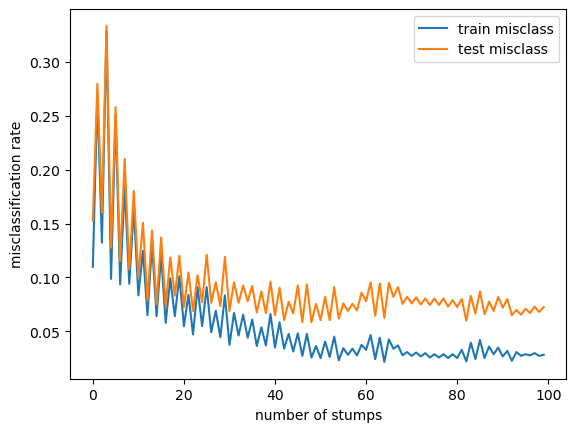

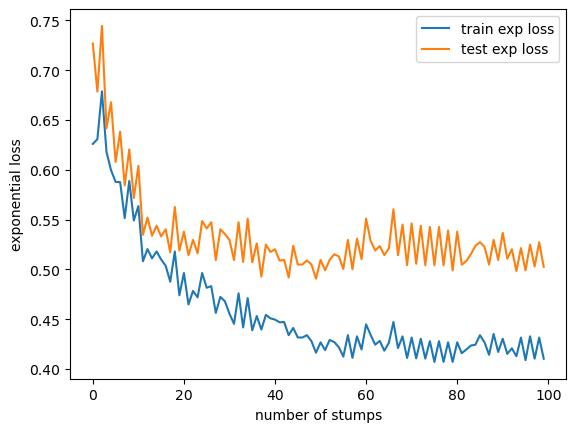

min train misclass 0.021450459652706845
min test misclass 0.05826217980914113
min train exp loss 0.40702015372374906
min test exp loss 0.4905859217843107


In [5]:
# Boosted decision stumps
# Build decision stumps and initialize weights as 1/m for m training examples
# Fit decision tree over weighted misclassiciation error

def get_stump(X,y,w):
    clf = tree.DecisionTreeClassifier(max_depth=1)
    clf = clf.fit(X,y,sample_weight=w)
    yhat = clf.predict(X)
    return clf, get_weighted_misclass(w,y,yhat)

weights = np.ones(len(ytrain)) / len(ytrain)
stumps = []
for i in range(100):
    clf, err = get_stump(Xtrain,ytrain,weights)
    stumps.append(clf)
    alpha = 0.5*np.log((1-err)/err)
    yhat = clf.predict(Xtrain)
    weights = weights*np.exp(-alpha*ytrain*yhat)
    weights = weights/np.sum(weights)

# Plot the misclassification rate, and exponential loss as a function of number of stumps

def plot_stumps(stumps,Xtrain,ytrain,Xtest,ytest):
    train_misclass = []
    test_misclass = []
    train_exp_loss = []
    test_exp_loss = []
    for i in range(1,len(stumps)+1):
        yhat_train = np.zeros(len(ytrain))
        yhat_test = np.zeros(len(ytest))
        for j in range(i):
            yhat_train += stumps[j].predict(Xtrain)
            yhat_test += stumps[j].predict(Xtest)
        yhat_train = np.sign(yhat_train)
        yhat_test = np.sign(yhat_test)
        train_misclass.append(get_misclassed(ytrain,yhat_train))
        test_misclass.append(get_misclassed(ytest,yhat_test))
        train_exp_loss.append(get_exp_loss(ytrain,yhat_train))
        test_exp_loss.append(get_exp_loss(ytest,yhat_test))
    plt.plot(train_misclass)
    plt.plot(test_misclass)
    plt.legend(['train misclass','test misclass'])
    plt.xlabel('number of stumps')
    plt.ylabel('misclassification rate')
    plt.show()
    plt.plot(train_exp_loss)
    plt.plot(test_exp_loss)
    plt.legend(['train exp loss','test exp loss'])
    plt.xlabel('number of stumps')
    plt.ylabel('exponential loss')
    plt.show()
    print('min train misclass', np.min(train_misclass))
    print('min test misclass', np.min(test_misclass))
    print('min train exp loss', np.min(train_exp_loss))
    print('min test exp loss', np.min(test_exp_loss))

plot_stumps(stumps,Xtrain,ytrain,Xtest,ytest)

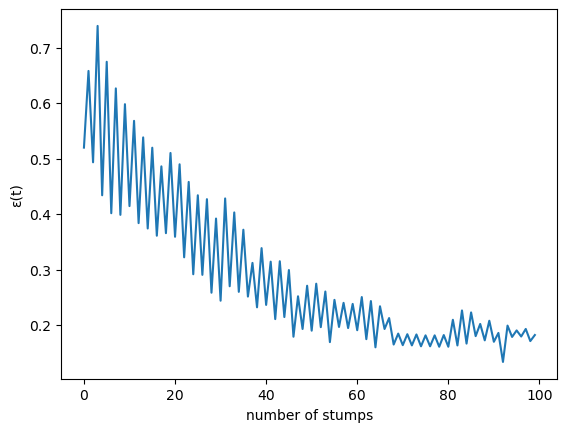

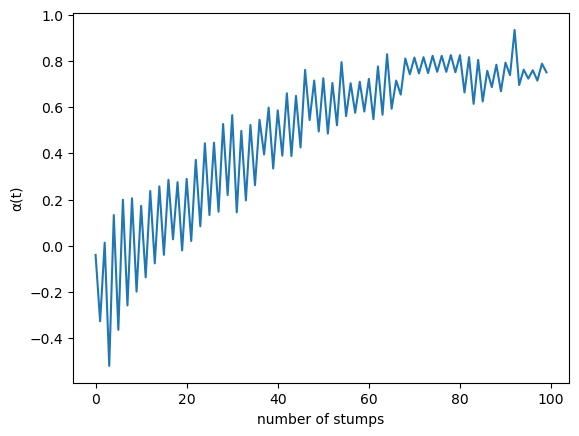

In [6]:
# Plot ε(t) and α(t) as a function of t

def plot_et_at(stumps,Xtrain,ytrain,Xtest,ytest):
    e = []
    a = []
    for i in range(1,len(stumps)+1):
        yhat_train = np.zeros(len(ytrain))
        yhat_test = np.zeros(len(ytest))
        for j in range(i):
            yhat_train += stumps[j].predict(Xtrain)
            yhat_test += stumps[j].predict(Xtest)
        yhat_train = np.sign(yhat_train)
        yhat_test = np.sign(yhat_test)
        err = get_weighted_misclass(weights,ytrain,yhat_train)
        alpha = 0.5*np.log((1-err)/err)
        e.append(err)
        a.append(alpha)
    plt.plot(e)
    plt.xlabel('number of stumps')
    plt.ylabel('ε(t)')
    plt.show()
    plt.plot(a)
    plt.xlabel('number of stumps')
    plt.ylabel('α(t)')
    plt.show()

plot_et_at(stumps,Xtrain,ytrain,Xtest,ytest)